# Trees and Forests

We will study some tree-based models using a different dataset, the wisconsin breast cancer dataset describe below:

In [1]:
import graphviz
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
cancer = load_breast_cancer()

In [3]:
print(cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

## Tree visualization
Let's start by building a very small tree (``max_depth=2``) and visualizing it.
The model fitting shouldn't be anything new:

In [5]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Scikit-learn has a way to export trees to ``dot`` graphs using the ``export_graphviz`` function: 

In [6]:
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
print(tree_dot)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="worst perimeter <= 106.1\ngini = 0.468\nsamples = 426\nvalue = [159, 267]", fillcolor="#399de567"] ;
1 [label="worst concave points <= 0.134\ngini = 0.081\nsamples = 259\nvalue = [11, 248]", fillcolor="#399de5f4"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.008\nsamples = 240\nvalue = [1, 239]", fillcolor="#399de5fe"] ;
1 -> 2 ;
3 [label="gini = 0.499\nsamples = 19\nvalue = [10, 9]", fillcolor="#e5813919"] ;
1 -> 3 ;
4 [label="worst concave points <= 0.142\ngini = 0.202\nsamples = 167\nvalue = [148, 19]", fillcolor="#e58139de"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.497\nsamples = 37\nvalue = [20, 17]", fillcolor="#e5813926"] ;
4 -> 5 ;
6 [label="gini = 0.03\nsamples = 130\nvalue = [128, 2]", fillcolor="#e58139fb"] ;
4 -> 6 ;
}


If you have graphviz installed, you can plot this using the following code. However, that's often a bit cumbersome, and I give an alternativ below.

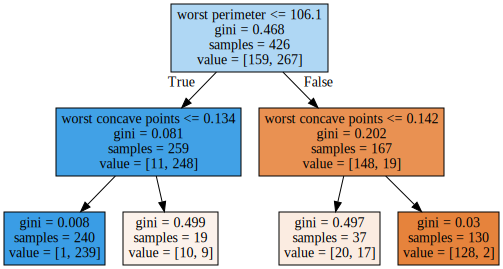

In [7]:
graphviz.Source(tree_dot)

I included a small function ``plot_tree`` in this lesson that can plot the tree without graphviz. It will hopefully be included in scikit-learn soon.

In [8]:
# I have python-graphviz, so no need for the following
# import from local file, not in sklearn yet
#from tree_plotting import plot_tree

#plot_tree(tree, feature_names=cancer.feature_names, filled=True)

### Task 1

Create a plot of the full tree, that is without limiting depth.
Then, create visualizations of trees with varying ``max_depth`` and ``max_leaf_nodes``. How are these trees different? Which do you think will generalize best?

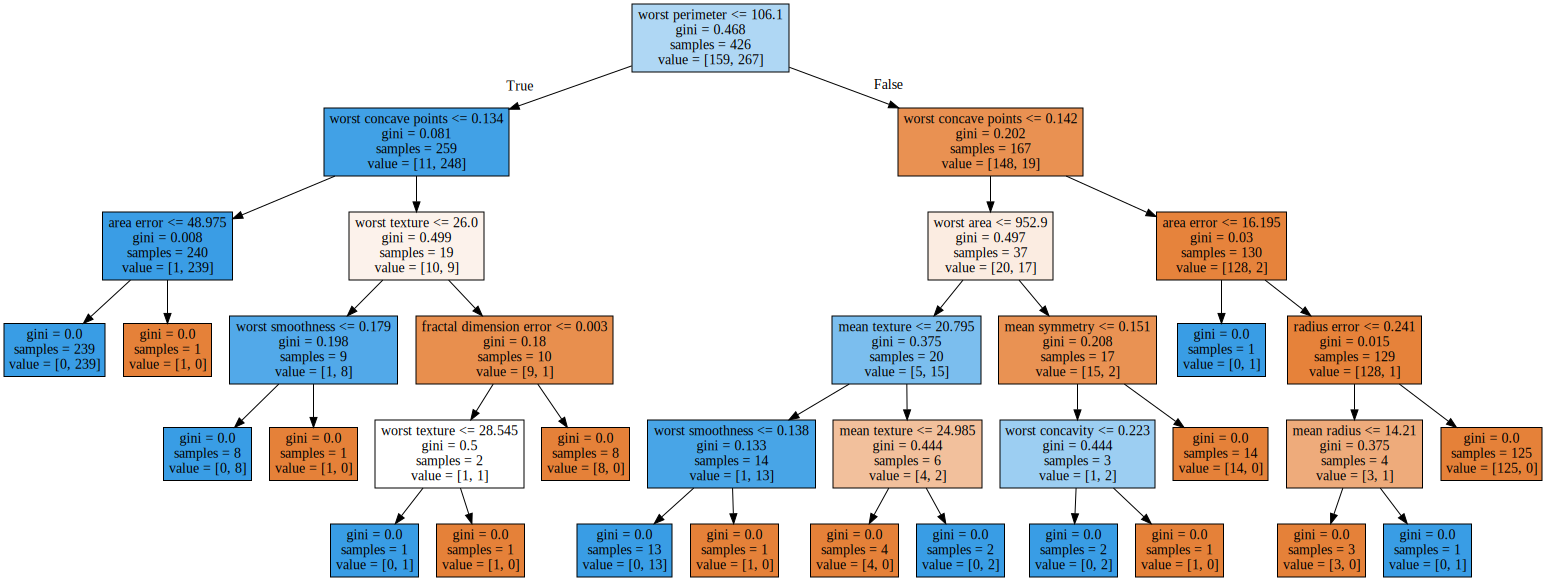

In [9]:
def getTree(max_depth, max_leaf_nodes):
    tree = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
    tree.fit(X_train, y_train)
    tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
    return tree_dot
    
graphviz.Source(getTree(None,None))

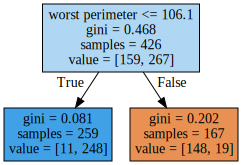

In [10]:
graphviz.Source(getTree(1,None))

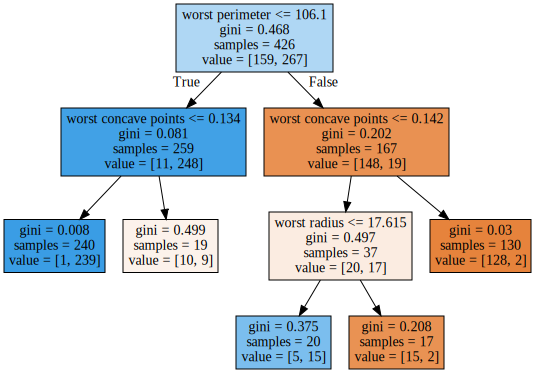

In [11]:
graphviz.Source(getTree(None,5))

# Parameter Tuning
### Task 2
Tune the ``max_leaf_nodes`` parameter using ``GridSearchCV``:

In [12]:
param_grid = {'max_leaf_nodes':  range(2,10)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
# inspect best parameters, compute test-set accuracy
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.923
best parameters: {'max_leaf_nodes': 6}
test-set score: 0.937


We can plot the tree that was fitted with the best parameters on the full training data by accessing ``grid.best_estimator_``:

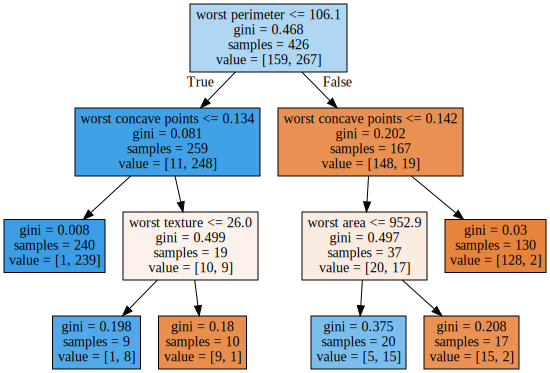

In [13]:
#plot_tree(grid.best_estimator_)
graphviz.Source(export_graphviz(grid.best_estimator_, out_file=None, feature_names=cancer.feature_names, filled=True))

It's easy to visualize the mean training set and  validation accuracy as we did in the last lab:

/usr/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


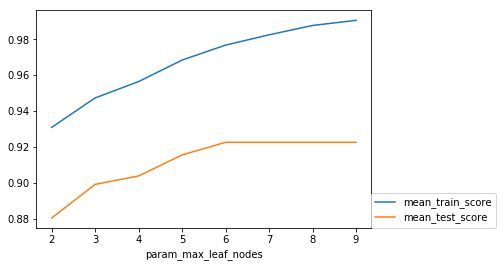

In [14]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))
plt.show()

### Task 3
Plot the feature importances of the ``best_estimator_`` using a bar chart.

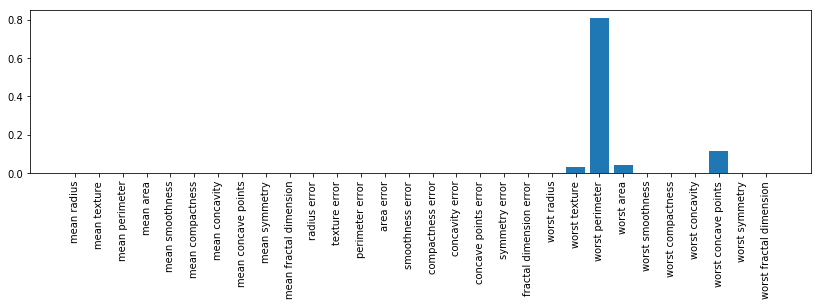

In [15]:
x = np.arange(len(grid.best_estimator_.feature_importances_))
fig, ax = plt.subplots(figsize=(14,3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.bar(x, grid.best_estimator_.feature_importances_)
plt.xticks(x, cancer.feature_names)
plt.show()

# Random Forests
While we could in theory visualize all the trees in a forest, they are random by design, and usually there are too many to look at.
So we'll skip the visualization, and go directly to parameter tuning

### Task 4
Tune the ``max_depth`` parameter of the ``RandomForestClassifier``. Make sure to set ``n_estimators`` to a large enough number (such as 100).

Plot the feature importances of the best random forest side-by-side with the feature importances of the best decision tree.

Finally, compare the precision recall curve of the best random forest with the best tree.

In [16]:
param_grid = {'max_depth':  range(1,10)}
grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=100), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.969
best parameters: {'max_depth': 5}
test-set score: 0.944


/usr/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


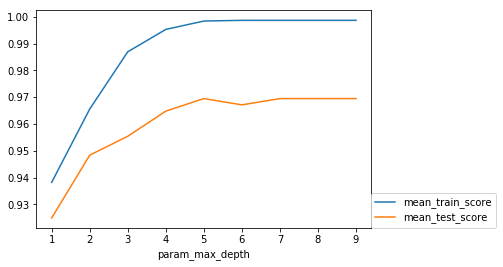

In [17]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))
plt.show()